In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
# Downloading wordnet before applying Lemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Data_Science/data.csv")

In [3]:
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [5]:
df1 = df[['Review text','Ratings']]

In [6]:
df1.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [7]:
df1.isnull().sum()

Review text    8
Ratings        0
dtype: int64

In [10]:
df1.dropna(inplace=True)

<ipython-input-10-e0e758ddcf8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.dropna(inplace=True)


In [13]:
df1

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1
...,...,...
8505,Delivered before time but price is high from m...,3
8506,up to the mark but same is available in market...,4
8507,Nice delivery speedREAD MORE,5
8508,No complaints about the item . Its the best on...,5


In [19]:
data = df1['Ratings'].value_counts().sort_index()

In [20]:
data

1     766
2     306
3     615
4    1744
5    5079
Name: Ratings, dtype: int64

<ipython-input-21-69b4e376fca0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=rating_counts.index,y=rating_counts.values,palette = "viridis")


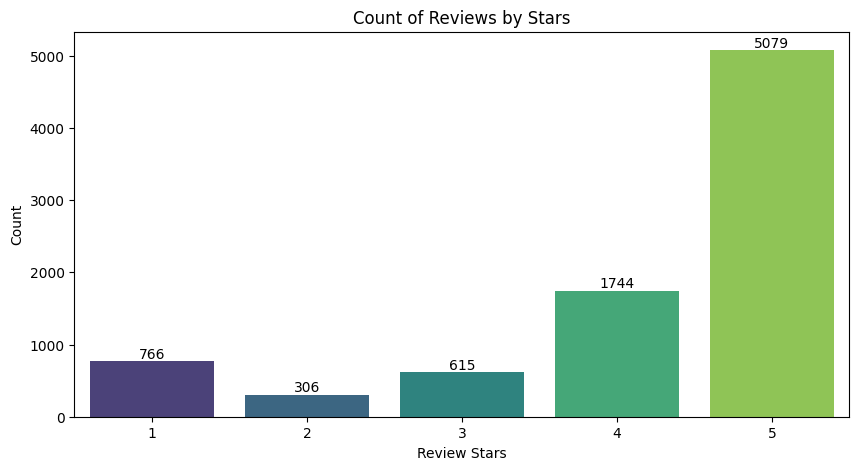

In [21]:

rating_counts = df1['Ratings'].value_counts().sort_index()
plt.figure(figsize=(10,5))
ax = sns.barplot(x=rating_counts.index,y=rating_counts.values,palette = "viridis")
ax.set_title('Count of Reviews by Stars')
ax.set_xlabel('Review Stars')
ax.set_ylabel('Count')

for i, count in enumerate(rating_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [22]:
def categorize_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating <= 2:
        return 'Negative'
    else:
        return 'Neutral'

df1['Sentiment'] = df1['Ratings'].apply(categorize_sentiment)

<ipython-input-22-908b8b9430b3>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Sentiment'] = df1['Ratings'].apply(categorize_sentiment)


In [23]:
df1

,Review text,Ratings,Sentiment
0,"Nice product, good quality, but price is now r...",4,Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,Worst product. Damaged shuttlecocks packed in ...,1,Negative
3,"Quite O. K. , but nowadays the quality of the...",3,Neutral
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Negative
...,...,...,...
8505,Delivered before time but price is high from m...,3,Neutral
8506,up to the mark but same is available in market...,4,Positive
8507,Nice delivery speedREAD MORE,5,Positive
8508,No complaints about the item . Its the best on...,5,Positive


In [24]:
df1['Sentiment'].value_counts(normalize=True)


Positive    0.801763
Negative    0.125969
Neutral     0.072268
Name: Sentiment, dtype: float64

In [29]:
senti_counts = df1['Sentiment'].value_counts().sort_index()

<ipython-input-31-87421e4137a2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax= sns.barplot(data=df1['Sentiment'].value_counts().sort_index(),palette='viridis')


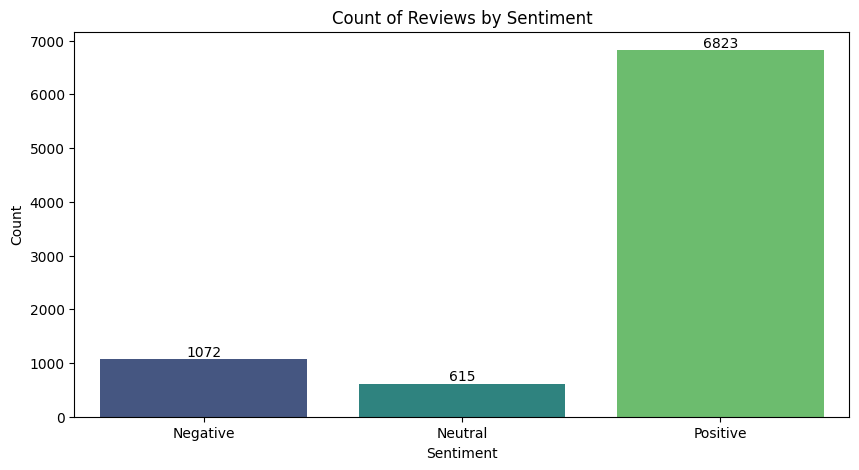

In [31]:
plt.figure(figsize=(10, 5))
ax= sns.barplot(data=df1['Sentiment'].value_counts().sort_index(),palette='viridis')
ax.set_title('Count of Reviews by Sentiment')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

for i, count in enumerate(senti_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

plt.show()

<Axes: xlabel='Sentiment', ylabel='Density'>

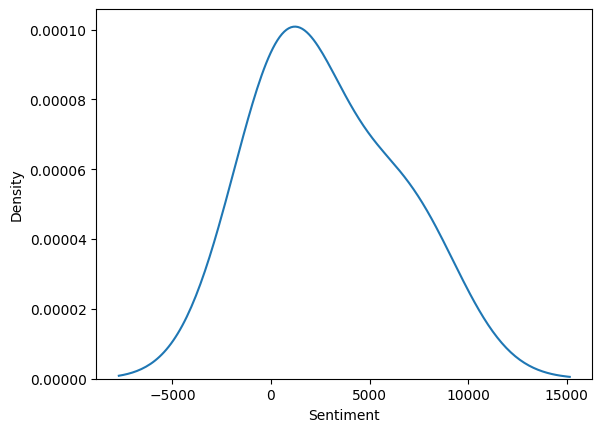

In [27]:
sns.kdeplot(data=df1['Sentiment'].value_counts())

In [32]:
df1['Review text'] = df1['Review text'].str.replace('READ MORE', '')


<ipython-input-32-96faf969c812>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Review text'] = df1['Review text'].str.replace('READ MORE', '')


In [33]:
df1=df1[df1['Sentiment']!='Neutral']


In [34]:
df1

,Review text,Ratings,Sentiment
0,"Nice product, good quality, but price is now r...",4,Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,1,Negative
2,Worst product. Damaged shuttlecocks packed in ...,1,Negative
4,Over pricedJust â?¹620 ..from retailer.I didn'...,1,Negative
5,Good quality product. Delivered on time.,5,Positive
...,...,...,...
8504,Received product intact and sealed,5,Positive
8506,up to the mark but same is available in market...,4,Positive
8507,Nice delivery speed,5,Positive
8508,No complaints about the item . Its the best on...,5,Positive


In [36]:
df1['Sentiment'].value_counts()

Positive    6823
Negative    1072
Name: Sentiment, dtype: int64

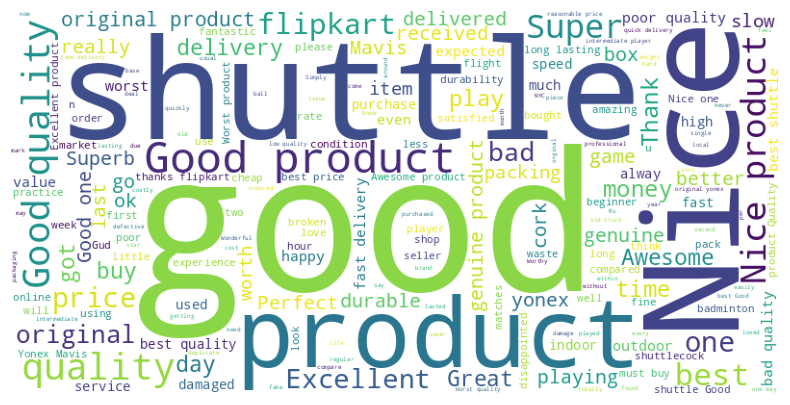

In [38]:

wc = WordCloud(background_color='white',
               width=800,
               height=400).generate(' '.join(df1['Review text']))
plt.figure(1,figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [57]:
X = df1[['Review text']]

In [58]:
y =df1['Sentiment']

In [131]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state= 42)

In [132]:
X_train.shape

(5921, 1)

In [133]:
X_test.shape

(1974, 1)

In [134]:
y_train.shape

(5921,)

In [135]:
y_test.shape

(1974,)

In [136]:
stemmer=PorterStemmer()
lemmatizer=WordNetLemmatizer()

In [137]:
def preprocess(text, flag):
    # remove special characters
    sentence = re.sub(r'[^a-zA-Z]', ' ', text)
    # convert sentence into lower case
    sentence = sentence.lower()
    # tokenize sentence into words
    tokens = sentence.split()
    # remove stop words
    clean_tokens = [token for token in tokens if token not in stopwords.words("english")]
    # stemming/lemmatization
    if flag == 'stem':
        clean_tokens = [stemmer.stem(token) for token in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
    return pd.Series(' '.join(clean_tokens))


In [138]:
%time
X_train_transformed = X_train['Review text'].progress_apply(lambda x: preprocess(x, flag='lemma'))
X_train_transformed.head()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


100%|██████████| 5921/5921 [00:05<00:00, 1020.48it/s]


,0
6230,important thing packing good nd cork good cond...
478,okay
1482,good
915,nice pic
7322,best quality


In [139]:

X_train_transformed.columns = ['clean_text_lemma']

X_train_transformed.head()

,clean_text_lemma
6230,important thing packing good nd cork good cond...
478,okay
1482,good
915,nice pic
7322,best quality


In [140]:
%time
X_test_transformed= X_test['Review text'].progress_apply(lambda x: preprocess(x, flag='lemma'))
X_test_transformed.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


100%|██████████| 1974/1974 [00:01<00:00, 1122.66it/s]


,0
8287,two shuttle defective star prompt delivery
5822,nice
5135,first time received bad quality product shuttl...
4214,great like
7924,good


In [141]:
X_test_transformed.columns = ['clean_text_lemma']

X_test_transformed.head()

,clean_text_lemma
8287,two shuttle defective star prompt delivery
5822,nice
5135,first time received bad quality product shuttl...
4214,great like
7924,good


In [142]:

from sklearn.feature_extraction.text import CountVectorizer

vocab = CountVectorizer()

X_train_bow = vocab.fit_transform(X_train_transformed['clean_text_lemma'])

print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 2010
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (5921, 2010)


In [143]:

X_test_bow = vocab.transform(X_test_transformed['clean_text_lemma'])

print("Shape of input data:", X_test_bow.shape)

Shape of input data: (1974, 2010)


# **Logistic Regression**

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report

classifier = LogisticRegression(penalty = 'elasticnet',  C=1.0, solver = 'saga', l1_ratio = 0.5, class_weight ='balanced')
classifier.fit(X_train_bow, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', l1_ratio=0.5, penalty='elasticnet',
                   solver='saga')

In [145]:
y_train_pred = classifier.predict(X_train_bow)
print("Accuracy on Train Data:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

Accuracy on Train Data: 0.9343016382367844
              precision    recall  f1-score   support

    Negative       0.71      0.87      0.78       802
    Positive       0.98      0.94      0.96      5119

    accuracy                           0.93      5921
   macro avg       0.84      0.91      0.87      5921
weighted avg       0.94      0.93      0.94      5921



In [146]:
output_df = pd.DataFrame({'Actual_pred':y_train})

In [147]:
output_df['Predicted'] = y_train_pred

In [148]:
output_df

,Actual_pred,Predicted
6230,Positive,Positive
478,Positive,Positive
1482,Negative,Positive
915,Positive,Positive
7322,Positive,Positive
...,...,...
5631,Positive,Positive
5802,Positive,Positive
928,Negative,Negative
8195,Positive,Positive


In [149]:
train_cm = metrics.confusion_matrix(y_train, y_train_pred)
train_actual = np.sum(train_cm, axis=1).reshape(-1, 1)

train_cmn = np.round(train_cm/train_actual, 2)

print("Normalized Confusion Matrix on Train Data:")
print(train_cmn)

Normalized Confusion Matrix on Train Data:
[[0.87 0.13]
 [0.06 0.94]]


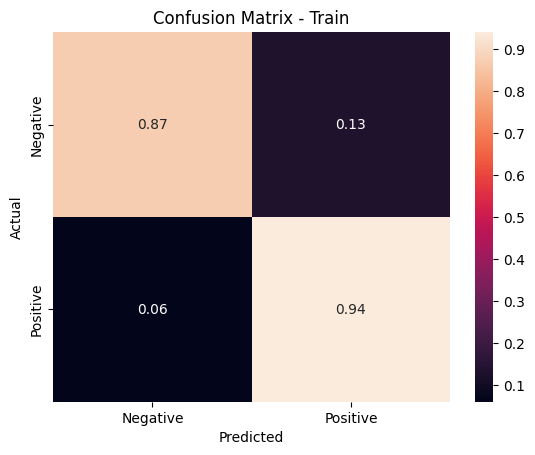

In [150]:
sns.heatmap(train_cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Train')
plt.show()

Accuracy on Test Data: 0.9052684903748733
              precision    recall  f1-score   support

    Negative       0.63      0.76      0.69       270
    Positive       0.96      0.93      0.94      1704

    accuracy                           0.91      1974
   macro avg       0.79      0.84      0.81      1974
weighted avg       0.91      0.91      0.91      1974

Normalized Confusion Matrix on Test Data: 
[[0.76 0.24]
 [0.07 0.93]]


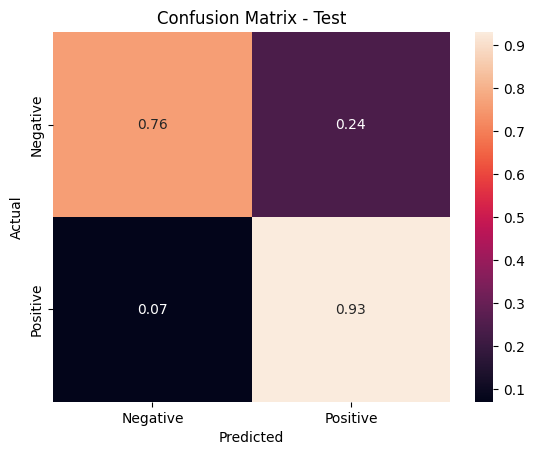

In [151]:
y_test_pred = classifier.predict(X_test_bow)
print("Accuracy on Test Data:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

test_cm = metrics.confusion_matrix(y_test, y_test_pred)
test_actual = np.sum(test_cm, axis=1).reshape(-1, 1)

test_cmn = np.round(test_cm/test_actual, 2)

print("Normalized Confusion Matrix on Test Data: ")
print(test_cmn)

sns.heatmap(test_cmn, annot=True, fmt='.2f', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.ylabel('Actual')

plt.xlabel('Predicted')
plt.title('Confusion Matrix - Test')
plt.show()


In [152]:
output_1 = pd.DataFrame({'Acutal':y_test})

In [153]:
output_1['Predicted_logisticRegression'] = y_test_pred

In [154]:
output_1

,Acutal,Predicted_logisticRegression
8287,Positive,Negative
5822,Positive,Positive
5135,Negative,Negative
4214,Positive,Positive
7924,Positive,Positive
...,...,...
6625,Positive,Positive
6502,Positive,Positive
1009,Positive,Negative
2093,Positive,Positive


# **Decision tree classifier**

In [155]:

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(max_depth=15)
classifier.fit(X_train_bow, y_train)

y_test_pred = classifier.predict(X_test_bow)

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9179331306990881
              precision    recall  f1-score   support

    Negative       0.83      0.51      0.63       270
    Positive       0.93      0.98      0.95      1704

    accuracy                           0.92      1974
   macro avg       0.88      0.75      0.79      1974
weighted avg       0.91      0.92      0.91      1974



In [156]:
output_1['Predicted_DecisionTreeClassifier'] = y_test_pred

In [157]:
output_1

,Acutal,Predicted_logisticRegression,Predicted_DecisionTreeClassifier
8287,Positive,Negative,Negative
5822,Positive,Positive,Positive
5135,Negative,Negative,Negative
4214,Positive,Positive,Positive
7924,Positive,Positive,Positive
...,...,...,...
6625,Positive,Positive,Positive
6502,Positive,Positive,Positive
1009,Positive,Negative,Positive
2093,Positive,Positive,Positive


In [158]:

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = classifier.predict(X_train_bow)

print(metrics.accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9378483364296571
              precision    recall  f1-score   support

    Negative       0.94      0.58      0.72       802
    Positive       0.94      0.99      0.97      5119

    accuracy                           0.94      5921
   macro avg       0.94      0.79      0.84      5921
weighted avg       0.94      0.94      0.93      5921



# **Multinomial**

In [163]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_bow, y_train) # train the model(timing it with an IPython "magic command")

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 53.1 ms


MultinomialNB()

In [164]:
from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_bow)

metrics.accuracy_score(y_train, y_train_pred)

0.9434217193041716

In [165]:

metrics.confusion_matrix(y_train, y_train_pred)

array([[ 555,  247],
       [  88, 5031]])

Text(0.5, 23.52222222222222, 'Predicted')

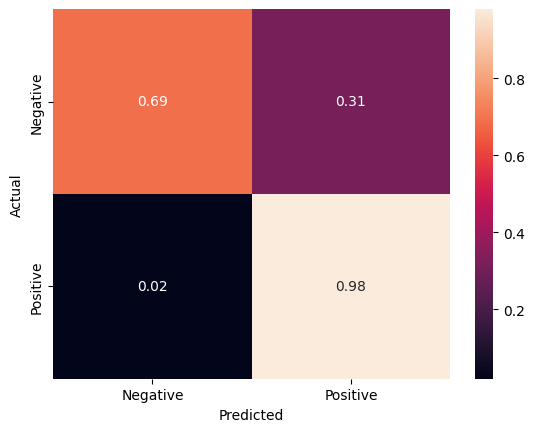

In [166]:

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [167]:

y_test_pred = nb.predict(X_test_bow)

metrics.accuracy_score(y_test, y_test_pred)

0.9300911854103343

Text(0.5, 23.52222222222222, 'Predicted')

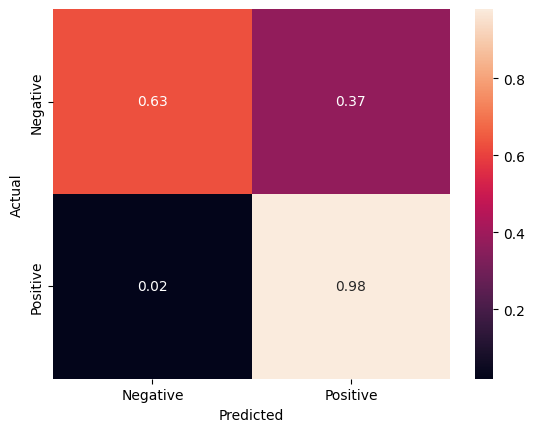

In [168]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [169]:

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred, average='weighted'))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train Score (F1 Score): 0.9407415572319521
Test Score (F1 Score): 0.9260357540408064


# **Random forest**


In [159]:

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier() # instantiate a Random Forest model
%time rf.fit(X_train_bow, y_train) # train the model(timing it with an IPython "magic command")

CPU times: user 2.77 s, sys: 11.4 ms, total: 2.79 s
Wall time: 2.92 s


RandomForestClassifier()

In [160]:

from sklearn import metrics
# make class predictions for X_train_dtm
y_train_pred = rf.predict(X_train_bow)

metrics.accuracy_score(y_train, y_train_pred)

0.9790575916230366

In [161]:

metrics.confusion_matrix(y_train, y_train_pred)

array([[ 706,   96],
       [  28, 5091]])

Text(0.5, 23.52222222222222, 'Predicted')

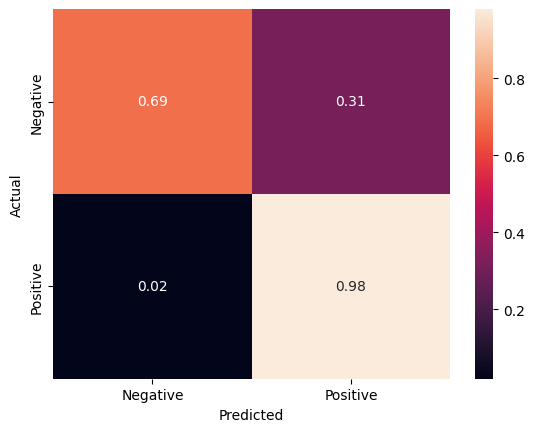

In [170]:

cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [172]:

y_test_pred = rf.predict(X_test_bow)

metrics.accuracy_score(y_test, y_test_pred)

0.9214792299898683

Text(0.5, 23.52222222222222, 'Predicted')

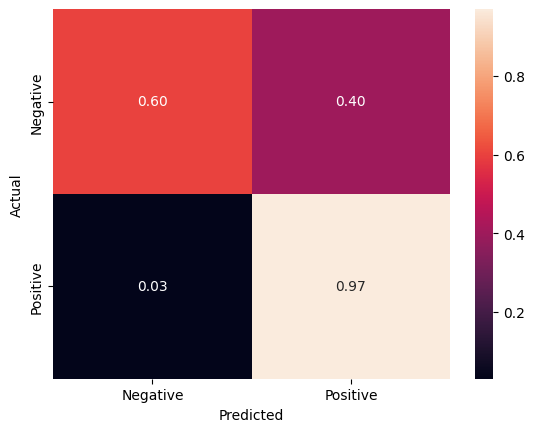

In [173]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [174]:

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred, average='weighted'))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred, average='weighted'))

Train Score (F1 Score): 0.9407415572319521
Test Score (F1 Score): 0.91733162439948


# **Hyperparameter tuning Random forest algorithm**

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Instantiate a Random Forest model
rf = RandomForestClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform hyperparameter tuning
%time grid_search.fit(X_train_bow, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Make predictions on training and test sets using the best model
best_rf_model = grid_search.best_estimator_
y_train_pred = best_rf_model.predict(X_train_bow)
y_test_pred = best_rf_model.predict(X_test_bow)

# Calculate accuracy on training and test sets
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

print("Accuracy on Train Data:", train_accuracy)
print("Accuracy on Test Data:", test_accuracy)

CPU times: user 15min 3s, sys: 1.71 s, total: 15min 5s
Wall time: 15min 25s
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score: 0.9282210058159425
Accuracy on Train Data: 0.9721330856274278
Accuracy on Test Data: 0.925531914893617


# **Creating a pickle file**

In [176]:
import pickle


In [178]:
pickle.dump(best_rf_model,open("best_rf_model.pkl",'wb'))


In [179]:
pickle.dump(vocab,open('count_vectorizer_vocab.pkl','wb'))